## Setup

In [2]:
# Install packages and frameworks

import tensorflow as tf
import os
import visualkeras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.utils import plot_model
from keras.callbacks import CSVLogger

# expecting 2.11
# if 2.7, than logging errors will show "Cleanup called..."
print(tf.__version__)

2023-06-01 23:43:17.750374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 23:43:17.869486: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-01 23:43:18.750422: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-01 23:43:18.750500: W tensorflow/

2.11.1


In [3]:
# manually set a filename to store and compare reports
os.environ['FILENAME'] = 'experiment'

In [25]:
# scratch directory is apart of the .gitignore to ensure it is not committed to git
%env SCRATCH=../scratch
! [ -e "${SCRATCH}" ] || mkdir -p "${SCRATCH}"

scratch_path = os.environ.get('SCRATCH', './scratch')

env: SCRATCH=../scratch


# Load the saved datasets

The TFRecord format is a simple format for storing a sequence of binary records.

## Load train

In [26]:
path = scratch_path + '/tf_datasets/train/'
train_ds = tf.data.Dataset.load(path)
train_ds.element_spec

2023-06-01 18:53:02.367690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 18:53:02.399609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 18:53:02.480560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 18:53:02.484296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

## Load validate

In [27]:
path = scratch_path + '/tf_datasets/validate/'
validation_ds = tf.data.Dataset.load(path)
validation_ds.element_spec

(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

## Load test

In [28]:
path = scratch_path + '/tf_datasets/test/'
test_ds = tf.data.Dataset.load(path)
test_ds.element_spec

(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

## Configure the datasets for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

1. `Caching` a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.
1. `Prefetching` overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

[Optimising your input pipeline performance with tf.data (part 1)](https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4)

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Check the device spec

In [30]:
# display physical devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Create the model

tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

## Setup the layers

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the Image classification tutorial.

Here's an example of Python code using Keras to create a sequential classification model that accepts 96x96x1 input images.

In this example, we start with three convolutional layers, each followed by a max pooling layer to downsample the input. Then, we flatten the output from the convolutional layers and add two fully connected layers. Finally, we add an output layer with the number of classes and compile the model using an optimizer (e.g., Adam) and a loss function (e.g., categorical cross-entropy).

```
import tensorflow as tf    

model = tf.keras.Model(...)

# Run training on GPU
with tf.device('/gpu:0'):
    model.fit(...)

# Run inference on CPU
with tf.device('/cpu:0'):
    model.predict(...)
    
```

## Set some variables

In [31]:
# set variables for consistency
img_height = 96              # desired height
img_width = 96               # desired width
batch_size = 32              # batch inputs in 32
seed_train_validation = 42   # Must be same for train_ds and val_ds
validation_split = 0.3       # move 30% of the data into validation
class_names = ['left', 'right']

dataFormat="channels_last"
num_classes = len(class_names)
inputShape=(img_height, img_width, 1)
chanDim = -1

## Set up the layers
The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as tf.keras.layers.Dense, have parameters that are learned during training.


In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=inputShape),
    tf.keras.layers.Reshape(target_shape=inputShape),

    # layer 1
    tf.keras.layers.Conv2D(96, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # layer 2
    tf.keras.layers.Conv2D(96, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # layer 3
    tf.keras.layers.Conv2D(96, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # layer 4
    #tf.keras.layers.Conv2D(96, 3, activation='relu'),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # layer 5
    #tf.keras.layers.Conv2D(96, 3, activation='relu'),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes),
    tf.keras.layers.Softmax()
])

## Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
Optimizer —This is how the model is updated based on the data it sees and its loss function.
Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [33]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(
                from_logits=False,
                label_smoothing=0.0,
                axis=-1,
                #reduction=losses_utils.ReductionV2.AUTO,
                name='categorical_crossentropy'),
            metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 96, 96, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 96)        83040     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 96)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 96)        8

### Visualize the model architecture

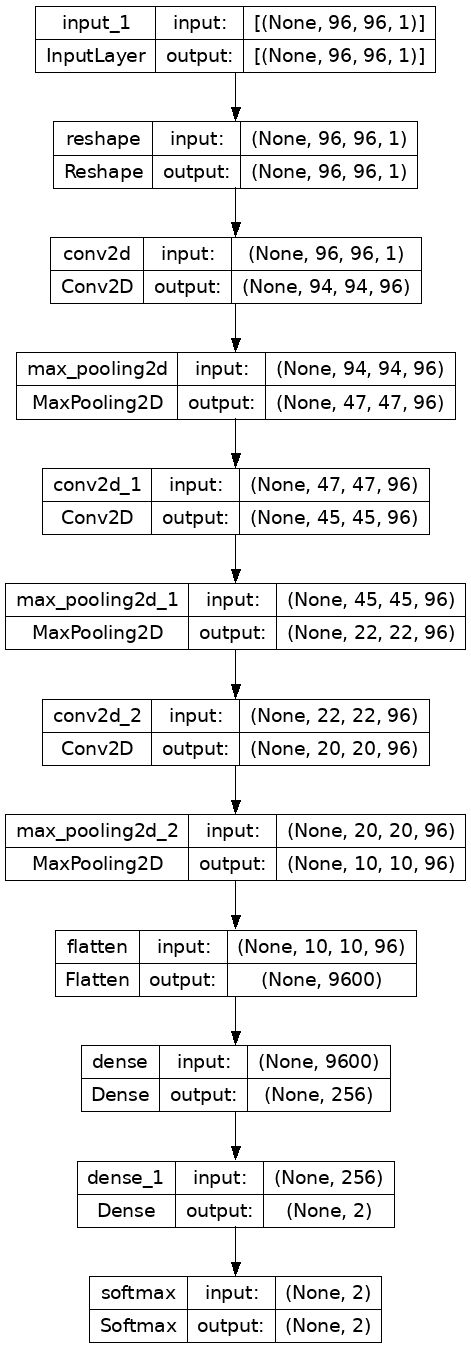

In [45]:
# Plot the resulting model architecture: https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model
filename = os.getenv('FILENAME')
to_file='../reports/' + filename + '-model_plot.png'
tf.keras.utils.plot_model(model, show_shapes=True,to_file=to_file)

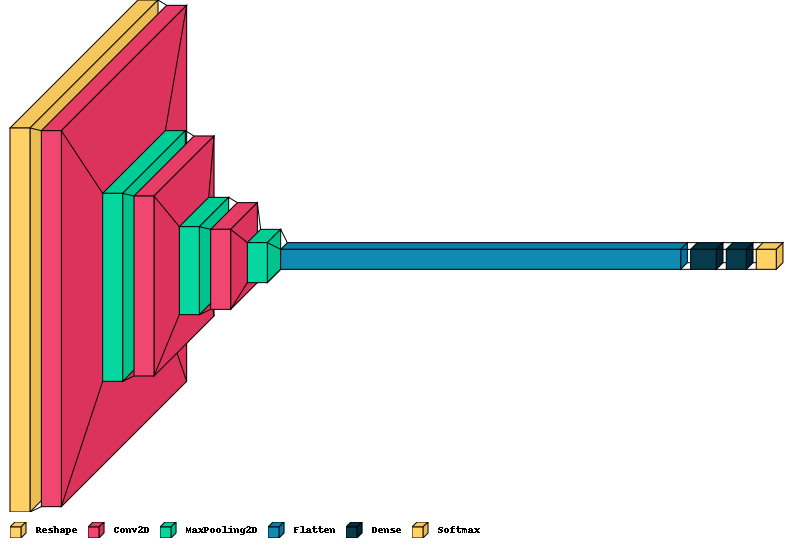

In [46]:
# Visualize the model
to_file='../reports/' + filename + '-model_visual.png'
visualkeras.layered_view(model, legend=True, draw_volume=True, to_file=to_file)

# Train the model
Training the neural network model requires the following steps:

Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
The model learns to associate images and labels.
You ask the model to make predictions about a test set—in this example, the test_images array.
Verify that the predictions match the labels from the test_labels array.

In [47]:
filename = '../reports/' + filename + '-score.csv'
csv_logger = CSVLogger(filename, append=True, separator=';')
model.fit(train_ds, epochs=10, validation_data=validation_ds, callbacks=[csv_logger])

Epoch 1/10


2023-06-01 18:59:00.307722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-06-01 18:59:01.244407: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f30b801ac80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-01 18:59:01.244458: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-06-01 18:59:01.251384: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-01 18:59:01.392441: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


393/393 [==============================] - 12s 21ms/step - loss: 1.9564 - accuracy: 0.5903 - val_loss: 0.6713 - val_accuracy: 0.5572
Epoch 2/10
393/393 [==============================] - 7s 18ms/step - loss: 0.6933 - accuracy: 0.5265 - val_loss: 0.6869 - val_accuracy: 0.5238
Epoch 3/10
393/393 [==============================] - 7s 18ms/step - loss: 0.6861 - accuracy: 0.5421 - val_loss: 0.6780 - val_accuracy: 0.5696
Epoch 4/10
393/393 [==============================] - 7s 18ms/step - loss: 0.6717 - accuracy: 0.6028 - val_loss: 0.6592 - val_accuracy: 0.6099
Epoch 5/10
393/393 [==============================] - 7s 18ms/step - loss: 0.6213 - accuracy: 0.6594 - val_loss: 0.5861 - val_accuracy: 0.6872
Epoch 6/10
393/393 [==============================] - 7s 18ms/step - loss: 0.6923 - accuracy: 0.6080 - val_loss: 0.6736 - val_accuracy: 0.5678
Epoch 7/10
393/393 [==============================] - 7s 18ms/step - loss: 0.6879 - accuracy: 0.5276 - val_loss: 0.6866 - val_accuracy: 0.5186
Epoch 8/1

# Evaluate the model

Next, compare how the model performs on the test dataset:

In [15]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

169/169 - 1s - loss: 0.5458 - accuracy: 0.7170 - 907ms/epoch - 5ms/step


# Score the model

In [17]:
# Generate generalization metrics
score = model.evaluate(test_ds, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.5458067655563354 / Test accuracy: 0.7170441746711731
